# Text Classification

Text classification is the process of categorizing the text into a group of words. By using NLP, text classification can automatically analyze text and then assign a set of predefined tags or categories based on its context. NLP is used for sentiment analysis, topic detection, and language detection.


# Sentiment Analysis
An especific case of text classification is **sentiment analysis**. This focuses on the polarity of a text (positive, negative, neutral) but it also goes beyond polarity to detect specific feelings and emotions.

# Preparing the Dataset 

We are going to use a [hate-speech spanish dataset](https://github.com/aymeam/Datasets-for-Hate-Speech-Detection). The main goal is to detect this kind of comments. 

In [ ]:
with open('/content/labeled_corpus_6K.txt') as file:
  lines = file.readlines()  

In [ ]:
lines = [line.strip('\n')[line.strip('\n').find(';||;'):].strip(';||;') for line in lines]
lines

In [ ]:
txt_corpus= [line[:line.find(';||;'):] for line in lines]
label =[line[line.find(';||;')+4:] for line in lines]

In [ ]:
print(f'Dataset information: {txt_corpus[10]}.\nSentiment detected: {label[10]}')

Dataset information: La gente que se pretende burlar del feminismo diciendo "machista opresor" es porque no ha cogido un libro en su puta vida y no sabe qué es.
Sentiment detected: 0


In [ ]:
from pysentimiento.preprocessing import preprocess_tweet

# Replaces user handles and URLs by special tokens
txt_corpus = [preprocess_tweet(i, shorten=2) for i in txt_corpus] 

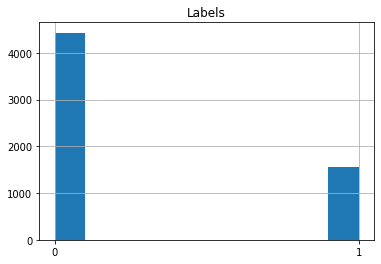

In [ ]:
import matplotlib.pyplot as plt

plt.title('Labels')
plt.hist(label)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.asarray(txt_corpus)
y = np.asarray(label)

In [ ]:
X_balanced_1 = [ X[i] for i in np.where(y=='1')[0]]
y_balanced_1 = [ 1 for i in np.where(y=='1')[0]]

In [ ]:
X_balanced_0 = [ X[i] for i in np.where(y=='0')[0]][:len(y_balanced_1)]
y_balanced_0 = [ 0 for i in np.where(y=='0')[0]][:len(y_balanced_1)]

In [ ]:
X = np.concatenate((X_balanced_1, X_balanced_0))
y = np.concatenate((y_balanced_1, y_balanced_0))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2020)

In [ ]:
print(X_train.shape, X_val.shape)

(2193,) (941,)


Cleaning the dataset with the data_cleaning's methods

In [ ]:
!pip3 install -r requirements.txt
!python -m spacy download en_core_web_sm
import data_cleaning.spanish as sp

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

cleaned_doc_train,entities = sp.corpus(dataset=X_train,twitter_mails_digit=True)
X_train_preprocessed = [" ".join(words_list) for words_list in cleaned_doc_train]

cleaned_doc_val,entities = sp.corpus(dataset=X_val,twitter_mails_digit=True)
X_val_preprocessed  = [" ".join(words_list) for words_list in cleaned_doc_val]

In [ ]:
# Calculate TF-IDF
tf_idf = TfidfVectorizer(binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

# Machine Learning models for NLP
Machine learning for NLP and text analytics involves a set of statistical techniques for identifying parts of speech, entities, sentiment, and other aspects of text. The techniques can be expressed as a model that is then applied to other text, also known as supervised machine learning. It also could be a set of algorithms that work across large sets of data to extract meaning, which is known as unsupervised machine learning. 

In [ ]:
model_name= []; vectors =[]; f1 = []; accuracy = []

## Support-vector machine (SVM)

FoR performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {
    "estimator__C": [1,2,4,8],
    "estimator__kernel": ["poly"],
    "estimator__degree":[1, 2],
}

cv = GridSearchCV(OneVsRestClassifier(SVC()), param_grid=parameters, scoring = 'f1_micro')

cv.fit(X_train_tfidf, y_train)

print(cv.best_score_)
print(cv.best_params_)

0.7172683870565107
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__kernel': 'poly'}


In [ ]:
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, classification_report,confusion_matrix

predictions = cv.best_estimator_.predict(X_val_tfidf)

f1_score(y_val, predictions, labels=[0,1],average = None) 

array([0.72406181, 0.74385246])

In [ ]:
print(f"Test Set Accuracy : {accuracy_score(y_val, predictions) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_val, predictions)}")

Test Set Accuracy : 73.43251859723698 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       456
           1       0.74      0.75      0.74       485

    accuracy                           0.73       941
   macro avg       0.73      0.73      0.73       941
weighted avg       0.73      0.73      0.73       941



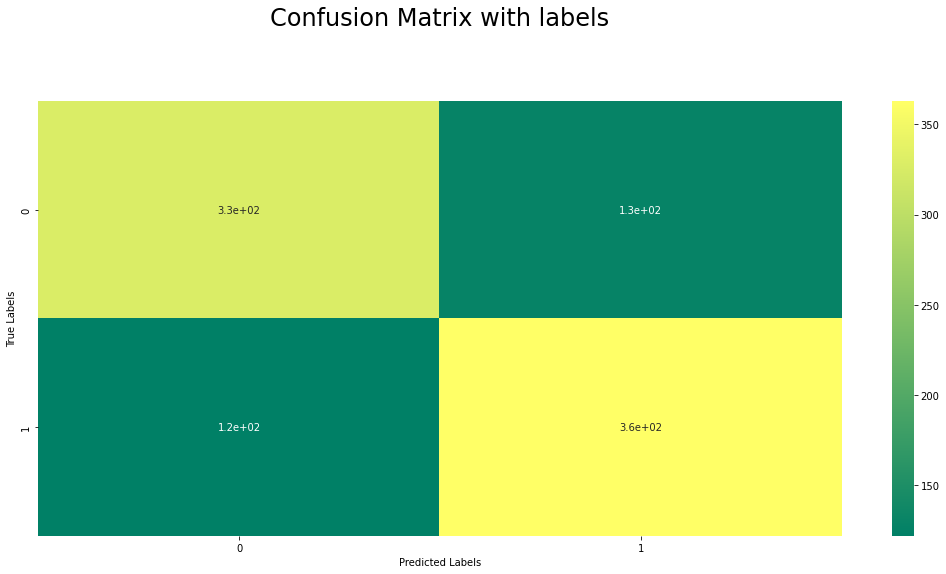

In [ ]:
import seaborn as sns
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_val, predictions), annot = True, xticklabels = [0,1], yticklabels = [0,1], cmap = 'summer')
plt.title('Confusion Matrix with labels\n\n', size=24, pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
for i in range(5):
  print('Prediction:'+ str(predictions[i])+ ', True label:'  + str(y_val[i]))


In [ ]:
model_name.append('Support Vector Machine')
vectors.append('TF-ID')
f1.append(f1_score(y_val, predictions) * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

## Random Forest Classifier (RFC)
Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = { 
    'n_estimators': [ 500, 600,700,800],
    'max_depth' : [7,8, 9, 10, 11]
 #   'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_tfidf, y_train)




GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [7, 8, 9, 10, 11],
                         'n_estimators': [500, 600, 700, 800]})

In [ ]:
print(CV_rfc.best_score_)
print(CV_rfc.best_params_)

0.6912784347988892
{'max_depth': 11, 'n_estimators': 700}


In [ ]:
import sklearn.metrics
predictions = CV_rfc.best_estimator_.predict(X_val_tfidf)

f1_score(y_val, predictions, average = None) 

array([0.70386266, 0.70947368])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Test Set Accuracy : {accuracy_score(y_val, predictions) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_val, predictions)}")

Test Set Accuracy : 70.66950053134963 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.69      0.72      0.70       456
           1       0.72      0.69      0.71       485

    accuracy                           0.71       941
   macro avg       0.71      0.71      0.71       941
weighted avg       0.71      0.71      0.71       941



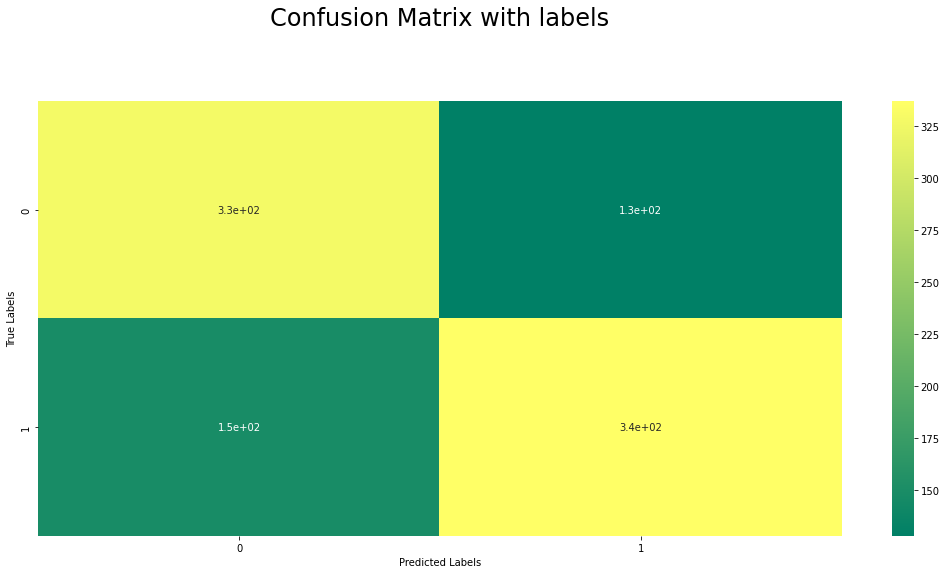

In [ ]:
import seaborn as sns
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_val, predictions), annot = True, xticklabels = [0,1], yticklabels = [0,1], cmap = 'summer')
plt.title('Confusion Matrix with labels\n\n', size=24, pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name.append('Random Forest Classifier')
vectors.append('TF-ID')
f1.append(f1_score(y_val, predictions) * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

https://www.kaggle.com/nkitgupta/evaluation-metrics-for-multi-class-classification/notebook

## Logistic Regression (LR)
Logistic Regression is a predictive analysis algorithm based on the concept of probability.

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg = LogisticRegression(max_iter=500)

CV_lr = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 5)
CV_lr.fit(X_train_tfidf, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [ ]:
print(CV_lr.best_score_)
print(CV_lr.best_params_)

0.7204688946443245
{'C': 1.0, 'penalty': 'l2'}


In [ ]:
import sklearn.metrics
predictions = CV_lr.best_estimator_.predict(X_val_tfidf)

f1_score(y_val, predictions, average = None) 

array([0.73420479, 0.74688797])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Test Set Accuracy : {accuracy_score(y_val, predictions) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_val, predictions)}")

Test Set Accuracy : 74.0701381509033 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       456
           1       0.75      0.74      0.75       485

    accuracy                           0.74       941
   macro avg       0.74      0.74      0.74       941
weighted avg       0.74      0.74      0.74       941



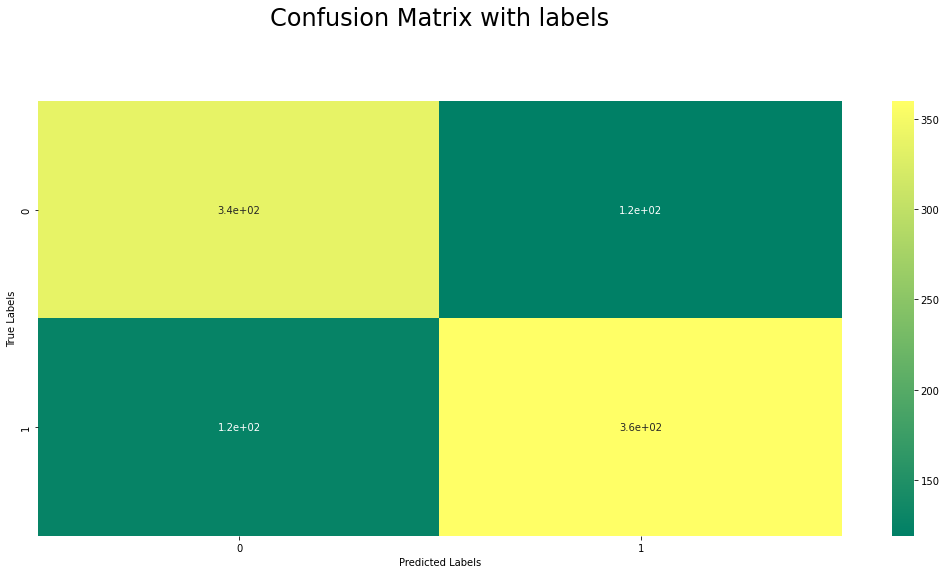

In [ ]:
import seaborn as sns
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_val, predictions), annot = True, xticklabels = [0,1], yticklabels = [0,1], cmap = 'summer')
plt.title('Confusion Matrix with labels\n\n', size=24, pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name.append('Logistic Regression')
vectors.append('TF-ID')
f1.append(f1_score(y_val, predictions) * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

ROC score method

In [ ]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [ ]:
roc_auc_dict = roc_auc_score_multiclass(y_val, predictions)
roc_auc_dict

{0: 0.7406515644782059, 1: 0.7406515644782058}

## Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. 

In [ ]:
from sklearn.naive_bayes import MultinomialNB

grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 1e-1, 1e-2] 
}

cv_nb = GridSearchCV(estimator=MultinomialNB(), param_grid=grid, verbose=1, cv=10, n_jobs=-1)
cv_nb.fit(X_train_tfidf, y_train)


Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 0.1, 0.01]},
             verbose=1)

In [ ]:
print(cv_nb.best_score_)
print(cv_nb.best_params_)

0.7204462432544625
{'alpha': 10.0}


In [ ]:
predictions_bayes = cv_nb.best_estimator_.predict(X_val_tfidf)

f1_score(y_val, predictions_bayes, average = None) 

array([0.71955307, 0.74569402])

In [ ]:
print(f"Test Set Accuracy : {accuracy_score(y_val, predictions_bayes) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_val, predictions_bayes)}")

Test Set Accuracy : 73.32624867162593 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       456
           1       0.73      0.76      0.75       485

    accuracy                           0.73       941
   macro avg       0.73      0.73      0.73       941
weighted avg       0.73      0.73      0.73       941



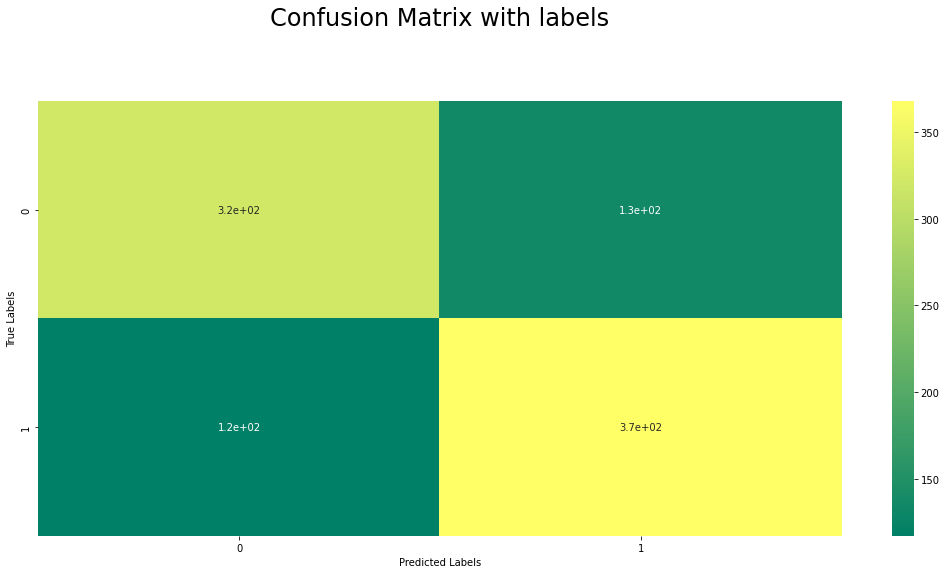

In [ ]:
import seaborn as sns
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_val, predictions_bayes), annot = True, xticklabels = [0,1], yticklabels = [0,1], cmap = 'summer')
plt.title('Confusion Matrix with labels\n\n', size=24, pad=20)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model_name.append('Naive Bayes')
vectors.append('TF-ID')
f1.append(f1_score(y_val, predictions_bayes) * 100)
accuracy.append(accuracy_score(y_val, predictions_bayes) * 100)

# Deep Learning models for NLP

## Transformer
The Transformer in NLP is a novel architecture that aims to solve sequence-to-sequence tasks while handling long-range dependencies with ease. The Transformer was proposed in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).


Source: https://chriskhanhtran.github.io/posts/bert-for-sentiment-analysis/

In [ ]:
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

--2022-02-22 14:30:53--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 390.88M  3.06MB/s    in 1m 46s  

2022-02-22 14:32:40 (3.68 MB/s) - ‘pytorch_weights.tar.gz’ saved [409871727/409871727]

--2022-02-22 14:32:40--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242120 (236K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>] 236.45K   578KB/s    in 0.4s 

In [ ]:
import torch
from transformers import BertForMaskedLM, BertTokenizer, BertForNextSentencePrediction
#BETO
tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)

In [ ]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([X_train_preprocessed, X_val_preprocessed])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  100


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train_preprocessed[0]])[0].squeeze().numpy())
print('Original: ', X_train_preprocessed[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train_preprocessed)
val_inputs, val_masks = preprocessing_for_bert(X_val_preprocessed)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  usuario subnormal escorio cateto humildad cristiano
Token IDs:  [4, 9127, 1884, 1420, 30936, 11987, 5545, 3726, 3316, 1071, 13215, 1109, 15911, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train) 
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('pytorch/')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 111 µs, sys: 3 µs, total: 114 µs
Wall time: 118 µs


In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
           
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t  for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future v

In [ ]:
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.666684   |     -      |     -     |  545.48  
   1    |   40    |   0.583439   |     -      |     -     |  515.15  
   1    |   60    |   0.589068   |     -      |     -     |  468.50  
   1    |   68    |   0.613844   |     -      |     -     |  184.53  
----------------------------------------------------------------------
   1    |    -    |   0.613931   |  0.530891  |   73.55   |  1934.18 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.431268   |     -      |     -     |  481.72  
   2    |   40    |   0.442191   |     -      |     -     |  457.57  
   2    |   60    |   0.394832   |     -      |     -     |  462.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_val_preprocessed)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
print(probs)


[[0.00841743 0.9915826 ]
 [0.992577   0.00742293]
 [0.03493276 0.96506727]
 ...
 [0.9920527  0.00794736]
 [0.9777141  0.02228589]
 [0.02682488 0.9731751 ]]


In [ ]:
test = probs[:,None].argmax(-1)
test

In [ ]:
f1_score(y_val, test, average = None) 

array([0.75027027, 0.75862069])

In [ ]:
model_name.append('Bert transformer')
vectors.append('Bert preprocess')
f1.append(f1_score(y_val, test) * 100)
accuracy.append(accuracy_score(y_val, test) * 100)

## Long Short Term Memory (LSTM) 
LSTM networks are a special type of RNN (Recurrent Neural Network) that is structured to remember and predict based on long-term dependencies that are trained with time-series data. 

[Sentiment Analysis with Gated Recurrent Units](https://krishisanskriti.org/vol_image/21Jul201503071043%20%20%20%20%20Faiyz%20Ahmad%202%20%20%20%20%20%20%20%20%2059-63.pdf)

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
total_reviews = X_train_preprocessed + X_val_preprocessed
tokenizer_obj.fit_on_texts(total_reviews) 

In [ ]:
max_length = len(max(total_reviews, key=len))
max_length

380

In [ ]:
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(X_train_preprocessed)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_val_preprocessed)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [ ]:
EMBEDDING_DIM = 128
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 380, 128)          942720    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,041,665
Trainable params: 1,041,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss',patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_BEST.h5'),
]

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=20, validation_data=(X_test_pad, y_val), batch_size=128, callbacks=my_callbacks)


Epoch 1/20
18/18 [==============================] - 10s 109ms/step - loss: 0.6881 - accuracy: 0.5609 - val_loss: 0.6760 - val_accuracy: 0.6408
Epoch 2/20
18/18 [==============================] - 1s 53ms/step - loss: 0.6303 - accuracy: 0.7091 - val_loss: 0.6184 - val_accuracy: 0.6865
Epoch 3/20
18/18 [==============================] - 1s 53ms/step - loss: 1.0664 - accuracy: 0.7273 - val_loss: 2.5728 - val_accuracy: 0.4846
Epoch 4/20
18/18 [==============================] - 1s 53ms/step - loss: 1.6677 - accuracy: 0.4979 - val_loss: 0.7327 - val_accuracy: 0.5154


In [ ]:
model.load_weights('/content/model_BEST.h5')

In [ ]:
score, acc = model.evaluate(X_test_pad, y_val)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

30/30 [==============================] - 0s 13ms/step - loss: 0.7327 - accuracy: 0.5154
Test score: 0.7327156066894531
Test accuracy: 0.5154091119766235
Accuracy: 51.54%


In [ ]:
predictions = model.predict(X_test_pad, batch_size=128)
predictions

In [ ]:
y_pred = ((predictions > 0.5)+0).ravel()

In [ ]:
model_name.append('Bidirectional LSTM')
vectors.append('Word Embedding')
f1.append(f1_score(y_val, y_pred) * 100)
accuracy.append(accuracy_score(y_val, y_pred) * 100)

# Pysentimiento library
This library works with a pretrained transformer. It is also trained with a twitter hate speech dataset.

[pysentimiento](https://github.com/pysentimiento/pysentimiento): A Python Toolkit for Sentiment Analysis and SocialNLP tasks

In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")
hate_speech_analyzer = create_analyzer(task="hate_speech", lang="es")

loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/25e0e805456d2786a12b70b86278c6e839d19958cb4f541ee1f78621140098f7.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/4fdf9a5a8e0a6023e1a9cdef62921158c3db9545e73f8dc0f46340a21bbb64d5.50a2bcf7668df2ff5a82b7b0455533bb4c0db21e6e33565fa20fd7dc8a3be740
loading file https://huggingface.co/pysentimiento/robertuito-sentiment-analysis/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/47dd2d3180a6186d30715516321375322e3a84d5e4656762e083091bbb5d5dc4.0843b07596b388e054bae078721182b4846b9e28a7bbf04d7

In [ ]:
hate_speech_analyzer.predict("Vaya guarra barata y de poca monta es Miley!")


AnalyzerOutput(output=['hateful', 'targeted', 'aggressive'], probas={hateful: 0.987, targeted: 0.980, aggressive: 0.973})

In [ ]:
from pysentimiento.preprocessing import preprocess_tweet

# Replaces user handles and URLs by special tokens
X_val_pysent = [preprocess_tweet(i, shorten=2) for i in X_val] # "@usuario debería cambiar esto url"


In [ ]:
predictions=[]
for i in X_val_pysent:
  ans= hate_speech_analyzer.predict(i)
  if len(ans.output) >0:
    predictions.append(1)
  else:
    predictions.append(0)

In [ ]:
f1_score(y_val, predictions) * 100

35.007610350076106

In [ ]:
model_name.append('Pysentimiento library')
vectors.append('Library pre-process')
f1.append(f1_score(y_val, predictions) * 100)
accuracy.append(accuracy_score(y_val, predictions) * 100)

# Results

In this section we compare the scores between models.

In [ ]:
import pandas as pd

df_results = pd.DataFrame({'Model':model_name, 'Preprocess text': vectors, 'F1-score':f1, 'Accuracy':accuracy})
df_results.sort_values(by='F1-score',ascending=False)

,Model,Preprocess text,F1-score,Accuracy
4,Bert transformer,Bert preprocess,75.862069,75.451647
2,Logistic Regression,TF-ID,74.688797,74.070138
3,Naive Bayes,TF-ID,74.569402,73.326249
0,Support Vector Machine,TF-ID,74.385246,73.432519
1,Random Forest Classifier,TF-ID,70.947368,70.669501
5,Bidirectional LSTM,Word Embedding,68.022440,51.540914
6,Pysentimiento library,Library pre-process,35.007610,54.622742
